In [1]:
import tensorflow as tf
#import tensorflow_io as tfio
print(tf.__version__)

import os
import random
import numpy as np
import matplotlib.pyplot as plt
import librosa

import ray
ray.init()

2.6.2


/home/nvidia/.local/lib/python3.8/site-packages/ray/_private/services.py:238: UserWarning: Not all Ray Dashboard dependencies were found. To use the dashboard please install Ray using `pip install ray[default]`. To disable this message, set RAY_DISABLE_IMPORT_WARNING env var to '1'.
  warnings.warn(warning_message)


{'node_ip_address': '192.168.1.15',
 'raylet_ip_address': '192.168.1.15',
 'redis_address': '192.168.1.15:6379',
 'object_store_address': '/tmp/ray/session_2022-05-23_22-00-47_184292_12331/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-05-23_22-00-47_184292_12331/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-05-23_22-00-47_184292_12331',
 'metrics_export_port': 41039,
 'node_id': '062cc29912fbecfca7e14516184d392a8b7bd90ff90a5663adf72eb5'}

In [2]:
SR = 16000


BG_PATH = '/home/nvidia/Desktop/Dataset/bg'

KW_PATH = '/home/nvidia/Desktop/엘레베이터용/train'
NEG_PATH = '/home/nvidia/Desktop/Dataset/neg'
SNEG_PATH = '/home/nvidia/Desktop/Dataset/sneg'
TEST_PATH = '/home/nvidia/Desktop/엘레베이터용/test'


KW = sorted(os.listdir(KW_PATH))
NEG = sorted(os.listdir(NEG_PATH))

bg_fnames = np.array(os.listdir(BG_PATH))
sneg_fnames = np.array(os.listdir(SNEG_PATH))

kw_fnames = []
neg_fnames = []
test_fnames = []

for i in range(len(KW)):
    kw_fnames.append(np.array(os.listdir(os.path.join(KW_PATH, KW[i]))))
    print(KW[i], kw_fnames[i].shape)
print('')

for i in range(len(KW)):
    test_fnames.append(np.array(os.listdir(os.path.join(TEST_PATH, KW[i]))))
    print(KW[i], test_fnames[i].shape)
print('')

for i in range(len(NEG)):
    neg_fnames.append(np.array(os.listdir(os.path.join(NEG_PATH, NEG[i]))))
    print(NEG[i], neg_fnames[i].shape)


구층 (1516,)
사층 (1817,)
삼층 (1578,)
십사층 (1656,)
십삼층 (1491,)
십오층 (1676,)
십이층 (1565,)
십일층 (1650,)
십층 (1098,)
오층 (1314,)
육층 (1374,)
이층 (1865,)
일층 (1844,)
칠층 (1733,)
팔층 (1168,)

구층 (40,)
사층 (40,)
삼층 (40,)
십사층 (40,)
십삼층 (40,)
십오층 (40,)
십이층 (40,)
십일층 (40,)
십층 (40,)
오층 (40,)
육층 (40,)
이층 (40,)
일층 (40,)
칠층 (40,)
팔층 (40,)

가지마 (593,)
걱정돼 (593,)
구해줘 (437,)
낮춰줘 (1024,)
내려줘 (592,)
놀아줘 (593,)
높여줘 (593,)
닫아줘 (593,)
더워 (593,)
뒤로 (593,)
들려줘 (1019,)
램프 (455,)
맞아 (593,)
무서워 (593,)
뭐야 (440,)
뭐하지 (593,)
바꿔줘 (593,)
방탄 (428,)
배고파 (592,)
불러줘 (593,)
불안해 (593,)
사랑해 (437,)
소리 (468,)
심심해 (593,)
아니야 (593,)
아이유 (439,)
안녕 (1036,)
앞으로 (591,)
엘이디 (444,)
열어줘 (592,)
오프 (428,)
온 (439,)
올려줘 (1033,)
은정 (439,)
읽어줘 (593,)
작게 (593,)
잘자 (1025,)
잘했어 (593,)
잠궈줘 (593,)
전원 (441,)
줄여줘 (593,)
최대로 (593,)
최소로 (592,)
추워 (573,)
축축해 (573,)
켜줘 (1025,)
크게 (592,)
키워줘 (593,)
틀어줘 (1024,)
힘들어 (592,)


In [3]:
filenames = []
targets = []

for i in range(len(KW)):
    for j in range(len(test_fnames[i])):
        filenames.append(os.path.join(TEST_PATH, KW[i], test_fnames[i][j]))
        targets.append(i + 1)

@tf.function
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    
    wav_seg = tf.pad(wav, [[0, 16000]], "CONSTANT")
    wav_seg = tf.slice(wav_seg, [0], [16000])
    
    return wav_seg

def load_wav_for_map(filename, label):
    return load_wav_16k_mono(filename), label

ds_test = tf.data.Dataset.from_tensor_slices((filenames, targets))
ds_test = ds_test.map(load_wav_for_map)
ds_test = ds_test.cache().batch(100).prefetch(tf.data.AUTOTUNE)

2022-05-23 22:00:49.318083: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 22:00:49.339628: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 22:00:49.340147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 22:00:49.341354: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
best_model = tf.keras.models.load_model(os.path.join('saved_model_5_23_ele1/', '93_0.825'))
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mfcc (MFCC)                  (None, 49, 10, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 25, 5, 64)         576       
_________________________________________________________________
batch_normalization (BatchNo (None, 25, 5, 64)         256       
_________________________________________________________________
re_lu (ReLU)                 (None, 25, 5, 64)         0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 25, 5, 64)         576       
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 5, 64)         256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 25, 5, 64)         0

2022-05-23 22:00:53.776069: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-23 22:00:54.778253: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-05-23 22:00:55.391208: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


<AxesSubplot:>

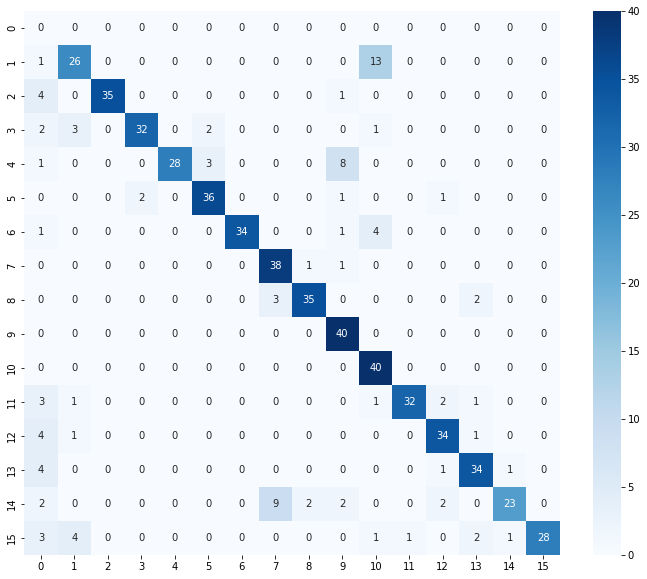

In [5]:
import seaborn as sns

count = np.zeros((int(len(KW)) + 1))
matrix = np.zeros((int(len(KW)) + 1, int(len(KW)) + 1))
for x, y in ds_test:
    pred = best_model.predict(x)
    count = count + np.pad(np.bincount(y), (0, int(len(KW)) + 1 - len(np.bincount(y))))
    matrix += tf.math.confusion_matrix(y, pred.argmax(axis=1), num_classes=int(len(KW)) + 1).numpy()
    #print(pred, count, matrix)

plt.figure(figsize=(12,10))
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
sns.heatmap(matrix.astype(np.int), annot=True, fmt="d", cmap="Blues")


<AxesSubplot:>

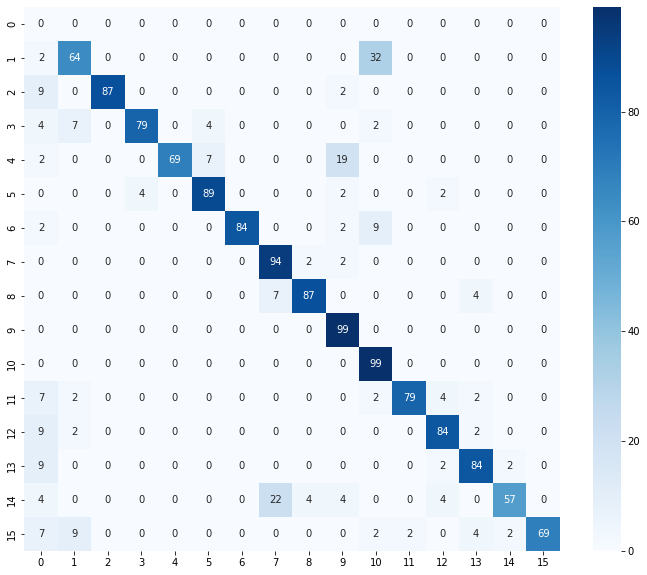

In [6]:
cm = (matrix / (count[:, np.newaxis] + 0.01) * 100)
plt.figure(figsize=(12,10))
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
sns.heatmap(cm.astype(np.int), annot=True, fmt="d", cmap="Blues")

In [7]:
class MFCC(tf.keras.layers.Layer):
    def __init__(self):
        super(MFCC, self).__init__()

    def call(self, signal):
        signal_stft = tf.signal.stft(tf.cast(signal, tf.float32),
                                     frame_length=640,
                                     frame_step=320,
                                     window_fn=self.periodic_hann_window)
        signal_spectrograms = tf.abs(signal_stft)
        
        linear_to_mel = tf.signal.linear_to_mel_weight_matrix(40,
                                                            signal_stft.shape[-1],
                                                            16000,
                                                            20.0,
                                                            4000.0)
        mel_spectrograms = tf.tensordot(signal_spectrograms, linear_to_mel, 1)
        mel_spectrograms.set_shape(mel_spectrograms.shape[:-1].concatenate(linear_to_mel.shape[-1:]))

        log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-12)
        signal_mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :10]
        
        return signal_mfccs[:, :, :, tf.newaxis]
    
    def periodic_hann_window(self, window_length, dtype):
        return 0.5 - 0.5 * tf.math.cos(2.0 *
                                       np.pi *
                                       tf.range(tf.cast(window_length, tf.float32)) /
                                       tf.cast(window_length, tf.float32))


In [8]:
model_folding_bn = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(16000)),
    MFCC(),

    tf.keras.layers.Conv2D(64, 3, (2, 2), 'same', input_shape=(49, 10, 1), name='CONV_1'),
    tf.keras.layers.ReLU(),

    tf.keras.layers.DepthwiseConv2D(3, (1, 1), 'same', name='CONV_2_DS'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(64, 1, (1, 1), 'same', name='CONV_2_PW'),
    tf.keras.layers.ReLU(),

    tf.keras.layers.DepthwiseConv2D(3, (1, 1), 'same', name='CONV_3_DS'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(64, 1, (1, 1), 'same', name='CONV_3_PW'),
    tf.keras.layers.ReLU(),

    tf.keras.layers.DepthwiseConv2D(3, (1, 1), 'same', name='CONV_4_DS'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(64, 1, (1, 1), 'same', name='CONV_4_PW'),
    tf.keras.layers.ReLU(),

    tf.keras.layers.DepthwiseConv2D(3, (1, 1), 'same', name='CONV_5_DS'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(64, 1, (1, 1), 'same', name='CONV_5_PW'),
    tf.keras.layers.ReLU(),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(KW) + 1, name='FC'),
    tf.keras.layers.Softmax(),
])

model_folding_bn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mfcc (MFCC)                  (None, 49, 10, 1)         0         
_________________________________________________________________
CONV_1 (Conv2D)              (None, 25, 5, 64)         640       
_________________________________________________________________
re_lu (ReLU)                 (None, 25, 5, 64)         0         
_________________________________________________________________
CONV_2_DS (DepthwiseConv2D)  (None, 25, 5, 64)         640       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 25, 5, 64)         0         
_________________________________________________________________
CONV_2_PW (Conv2D)           (None, 25, 5, 64)         4160      
_________________________________________________________________
re_lu_2 (ReLU)               (None, 25, 5, 64)         0

In [9]:
import numpy as np

p = 0
sigma = 0.001
layers = []
for layer in best_model.layers:
    print(layer, len(layer.get_weights()))
    if len(layer.get_weights()) == 1:
        weight = layer.get_weights()[0].copy()
    elif len(layer.get_weights()) == 4:
        gamma = layer.get_weights()[0].copy()
        beta = layer.get_weights()[1].copy()
        mean = layer.get_weights()[2].copy()
        var = layer.get_weights()[3].copy()

        scale = gamma / np.sqrt(var + sigma)
        bias = beta - (gamma * mean / np.sqrt(var + sigma))
        if weight.shape[3] == 1:
           scale = scale[:, np.newaxis]
        weight = weight * scale

        layers.append([weight, bias])

    elif len(layer.get_weights()) == 2:
        layers.append(layer.get_weights())

for layer in model_folding_bn.layers:
    if len(layer.get_weights()) != 0:
        layer.set_weights(layers[p])
        p += 1

<keras.saving.saved_model.load.MFCC object at 0x7fb445d458e0> 0
<keras.layers.convolutional.Conv2D object at 0x7fb1680c0250> 1
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb1680c08e0> 4
<keras.layers.advanced_activations.ReLU object at 0x7fb1680c0b20> 0
<keras.layers.convolutional.DepthwiseConv2D object at 0x7fb445cc7520> 1
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb445cc7c70> 4
<keras.layers.advanced_activations.ReLU object at 0x7fb150096430> 0
<keras.layers.convolutional.Conv2D object at 0x7fb150096880> 1
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb150099070> 4
<keras.layers.advanced_activations.ReLU object at 0x7fb150099160> 0
<keras.layers.convolutional.DepthwiseConv2D object at 0x7fb150099b50> 1
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb15009d2e0> 4
<keras.layers.advanced_activations.ReLU object at 0x7fb15009d4c0> 0
<keras.layers.

In [10]:
f = open('dscnn.h', 'w')

f.write('#ifndef DSCNN_H\r\n')
f.write('#define DSCNN_H\r\n')
f.write('\r\n')
f.write('#include "dl_lib_matrix3dq.h"\r\n')
f.write('#include "esp_log.h"\r\n')
f.write('\r\n')

for layer in model_folding_bn.layers:
    for i in range(len(layer.get_weights())):
        layer_name = layer.get_config()['name'].upper() + '_' + str(i + 1)
        if len(np.array(layer.get_weights()[i]).shape) == 4:
            layer_weights = np.reshape(np.transpose(layer.get_weights()[i], (3, 0, 1, 2)), (-1))
        else:
            layer_weights = np.reshape(np.transpose(layer.get_weights()[i]), (-1))
        
        min_value = layer_weights.min()
        max_value = layer_weights.max()
        int_bits = int(np.ceil(np.log2(max(abs(min_value),abs(max_value)))))
        dec_bits = 7 - int_bits
        layer_weights = np.round(layer_weights*2**dec_bits)
        print(len(np.array(layer.get_weights()[i]).shape), layer_name, layer.get_weights()[i].shape, layer_weights.shape, (min_value, max_value), dec_bits)

        f.write('#define ' + layer_name + ' {')
        for weight in layer_weights:
            f.write('{:d},'.format(int(weight)))
        f.write('}\r\n')

f.write('\r\n')
f.write('void dscnn_init();\r\n')
f.write('int dscnn_run(int16_t * in_data);\r\n')
f.write('\r\n')
f.write('#endif\r\n')
f.write('\r\n')

f.close()

4 CONV_1_1 (3, 3, 1, 64) (576,) (-0.3703833, 0.40307087) 8
1 CONV_1_2 (64,) (64,) (-0.58590496, 0.7750882) 7
4 CONV_2_DS_1 (3, 3, 64, 1) (576,) (-3.990328, 5.644241) 4
1 CONV_2_DS_2 (64,) (64,) (-1.1548165, 2.656465) 5
4 CONV_2_PW_1 (1, 1, 64, 64) (4096,) (-0.8341322, 0.9836501) 7
1 CONV_2_PW_2 (64,) (64,) (-1.7666279, 3.0281186) 5
4 CONV_3_DS_1 (3, 3, 64, 1) (576,) (-2.2331069, 4.140567) 4
1 CONV_3_DS_2 (64,) (64,) (-1.9324145, 2.1268294) 5
4 CONV_3_PW_1 (1, 1, 64, 64) (4096,) (-0.94112, 0.8089166) 7
1 CONV_3_PW_2 (64,) (64,) (-1.6272516, 2.4953222) 5
4 CONV_4_DS_1 (3, 3, 64, 1) (576,) (-1.50434, 1.9390118) 6
1 CONV_4_DS_2 (64,) (64,) (-1.8104558, 2.8718503) 5
4 CONV_4_PW_1 (1, 1, 64, 64) (4096,) (-0.72064656, 0.92799145) 7
1 CONV_4_PW_2 (64,) (64,) (-1.8070748, 1.5413382) 6
4 CONV_5_DS_1 (3, 3, 64, 1) (576,) (-1.2319767, 4.7690053) 4
1 CONV_5_DS_2 (64,) (64,) (-1.8551536, 2.8659134) 5
4 CONV_5_PW_1 (1, 1, 64, 64) (4096,) (-1.6320385, 2.0317996) 5
1 CONV_5_PW_2 (64,) (64,) (-1.804026,

In [12]:
# esp 7->15 (because 16bit)

f = open('dscnn.h', 'w')

f.write('#ifndef DSCNN_H\r\n')
f.write('#define DSCNN_H\r\n')
f.write('\r\n')
f.write('#include "dl_lib_matrix3dq.h"\r\n')
f.write('#include "esp_log.h"\r\n')
f.write('\r\n')

for layer in model_folding_bn.layers:
    for i in range(len(layer.get_weights())):
        layer_name = layer.get_config()['name'].upper() + '_' + str(i + 1)
        if len(np.array(layer.get_weights()[i]).shape) == 4:
            layer_weights = np.reshape(np.transpose(layer.get_weights()[i], (3, 0, 1, 2)), (-1))
        else:
            layer_weights = np.reshape(np.transpose(layer.get_weights()[i]), (-1))
        
        min_value = layer_weights.min()
        max_value = layer_weights.max()
        int_bits = int(np.ceil(np.log2(max(abs(min_value),abs(max_value)))))
        dec_bits = 15 - int_bits
        layer_weights = np.round(layer_weights*2**dec_bits)
        print(len(np.array(layer.get_weights()[i]).shape), layer_name, layer.get_weights()[i].shape, layer_weights.shape, (min_value, max_value), dec_bits)

        f.write('#define ' + layer_name + ' {')
        for weight in layer_weights:
            f.write('{:d},'.format(int(weight)))
        f.write('}\r\n')

f.write('\r\n')
f.write('void dscnn_init();\r\n')
f.write('int dscnn_run(int16_t * in_data);\r\n')
f.write('\r\n')
f.write('#endif\r\n')
f.write('\r\n')

f.close()

4 CONV_1_1 (3, 3, 1, 64) (576,) (-0.3703833, 0.40307087) 16
1 CONV_1_2 (64,) (64,) (-0.58590496, 0.7750882) 15
4 CONV_2_DS_1 (3, 3, 64, 1) (576,) (-3.990328, 5.644241) 12
1 CONV_2_DS_2 (64,) (64,) (-1.1548165, 2.656465) 13
4 CONV_2_PW_1 (1, 1, 64, 64) (4096,) (-0.8341322, 0.9836501) 15
1 CONV_2_PW_2 (64,) (64,) (-1.7666279, 3.0281186) 13
4 CONV_3_DS_1 (3, 3, 64, 1) (576,) (-2.2331069, 4.140567) 12
1 CONV_3_DS_2 (64,) (64,) (-1.9324145, 2.1268294) 13
4 CONV_3_PW_1 (1, 1, 64, 64) (4096,) (-0.94112, 0.8089166) 15
1 CONV_3_PW_2 (64,) (64,) (-1.6272516, 2.4953222) 13
4 CONV_4_DS_1 (3, 3, 64, 1) (576,) (-1.50434, 1.9390118) 14
1 CONV_4_DS_2 (64,) (64,) (-1.8104558, 2.8718503) 13
4 CONV_4_PW_1 (1, 1, 64, 64) (4096,) (-0.72064656, 0.92799145) 15
1 CONV_4_PW_2 (64,) (64,) (-1.8070748, 1.5413382) 14
4 CONV_5_DS_1 (3, 3, 64, 1) (576,) (-1.2319767, 4.7690053) 12
1 CONV_5_DS_2 (64,) (64,) (-1.8551536, 2.8659134) 13
4 CONV_5_PW_1 (1, 1, 64, 64) (4096,) (-1.6320385, 2.0317996) 13
1 CONV_5_PW_2 (64,) 

2022-05-25 02:57:46,196	WARNING worker.py:1215 -- The node with node id: 062cc29912fbecfca7e14516184d392a8b7bd90ff90a5663adf72eb5 and ip: 192.168.1.15 has been marked dead because the detector has missed too many heartbeats from it. This can happen when a raylet crashes unexpectedly or has lagging heartbeats.
2022-05-25 02:58:14,497	WARNING worker.py:1215 -- The autoscaler failed with the following error:
Traceback (most recent call last):
  File "/home/nvidia/.local/lib/python3.8/site-packages/ray/autoscaler/_private/monitor.py", line 324, in run
    self._run()
  File "/home/nvidia/.local/lib/python3.8/site-packages/ray/autoscaler/_private/monitor.py", line 214, in _run
    self.update_load_metrics()
  File "/home/nvidia/.local/lib/python3.8/site-packages/ray/autoscaler/_private/monitor.py", line 176, in update_load_metrics
    response = self.gcs_node_resources_stub.GetAllResourceUsage(
  File "/home/nvidia/.local/lib/python3.8/site-packages/grpc/_channel.py", line 946, in __call__


: 